In [231]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

In [16]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("../data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

In [17]:
def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

In [18]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

In [19]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

In [20]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


True

In [21]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


In [22]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

In [23]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

In [107]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 2.396919
Epoch 1, loss: 2.330424
Epoch 2, loss: 2.311241
Epoch 3, loss: 2.304605
Epoch 4, loss: 2.302070
Epoch 5, loss: 2.301581
Epoch 6, loss: 2.301429
Epoch 7, loss: 2.302322
Epoch 8, loss: 2.302208
Epoch 9, loss: 2.301598


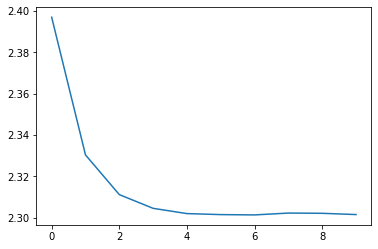

In [108]:
# let's look at the loss history!
plt.plot(loss_history)

In [91]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
loss_history = classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.121
Epoch 0, loss: 2.302215
Epoch 1, loss: 2.301985
Epoch 2, loss: 2.302737
Epoch 3, loss: 2.300975
Epoch 4, loss: 2.301442
Epoch 5, loss: 2.302421
Epoch 6, loss: 2.301731
Epoch 7, loss: 2.302419
Epoch 8, loss: 2.302720
Epoch 9, loss: 2.302479
Epoch 10, loss: 2.301701
Epoch 11, loss: 2.302557
Epoch 12, loss: 2.302107
Epoch 13, loss: 2.301509
Epoch 14, loss: 2.302106
Epoch 15, loss: 2.301887
Epoch 16, loss: 2.301371
Epoch 17, loss: 2.302466
Epoch 18, loss: 2.302819
Epoch 19, loss: 2.301781
Epoch 20, loss: 2.301586
Epoch 21, loss: 2.302168
Epoch 22, loss: 2.301653
Epoch 23, loss: 2.301711
Epoch 24, loss: 2.302092
Epoch 25, loss: 2.302354
Epoch 26, loss: 2.302117
Epoch 27, loss: 2.301351
Epoch 28, loss: 2.303007
Epoch 29, loss: 2.301711
Epoch 30, loss: 2.301495
Epoch 31, loss: 2.302072
Epoch 32, loss: 2.301860
Epoch 33, loss: 2.301866
Epoch 34, loss: 2.302525
Epoch 35, loss: 2.300940
Epoch 36, loss: 2.302256
Epoch 37, loss: 2.302481
Epoch 38, loss: 2.302122
Epoch 39, loss: 2.

In [242]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
reg_strengths = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = None

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

accuracy_arr=[]
W = []
for lr in learning_rates:
    for reg in reg_strengths:
        _train_X, _train_y, _valid_X, _valid_y = random_split_train_val(train_X, train_y, num_val=int(len(train_y)*0.2))
        _classifier = linear_classifer.LinearSoftmaxClassifier()
        _classifier.fit(_train_X, _train_y, epochs=10, learning_rate=lr, batch_size=300, reg=reg)
        _pred = _classifier.predict(_valid_X)
        _accuracy = multiclass_accuracy(_pred, _valid_y)
        accuracy_arr.append(_accuracy)
        W.append(_classifier.W.copy())
        print(f'learning_rate: {lr}, reg_strength: {reg}, accuracy: {_accuracy}')
best_val_accuracy = np.max(accuracy_arr)
best_classifier = linear_classifer.LinearSoftmaxClassifier()
best_classifier.W = W[np.argmax(accuracy_arr)]

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 2.294934
Epoch 1, loss: 2.263920
Epoch 2, loss: 2.271790
Epoch 3, loss: 2.256176
Epoch 4, loss: 2.256069
Epoch 5, loss: 2.287474
Epoch 6, loss: 2.272054
Epoch 7, loss: 2.274345
Epoch 8, loss: 2.277405
Epoch 9, loss: 2.274664
learning_rate: 0.1, reg_strength: 0.1, accuracy: 0.18833333333333332
Epoch 0, loss: 2.280240
Epoch 1, loss: 2.229189
Epoch 2, loss: 2.220998
Epoch 3, loss: 2.188020
Epoch 4, loss: 2.176676
Epoch 5, loss: 2.231796
Epoch 6, loss: 2.190227
Epoch 7, loss: 2.202590
Epoch 8, loss: 2.200088
Epoch 9, loss: 2.192591
learning_rate: 0.1, reg_strength: 0.01, accuracy: 0.2222222222222222
Epoch 0, loss: 2.278178
Epoch 1, loss: 2.223304
Epoch 2, loss: 2.210905
Epoch 3, loss: 2.172889
Epoch 4, loss: 2.157263
Epoch 5, loss: 2.214601
Epoch 6, loss: 2.165586
Epoch 7, loss: 2.178968
Epoch 8, loss: 2.172063
Epoch 9, loss: 2.162317
learning_rate: 0.1, reg_strength: 0.001, accuracy: 0.23
Epoch 0, loss: 2.277964
Epoch 1, loss: 2.222678
Epoch 2, loss: 2.209807
Epoch 3, loss:

Epoch 8, loss: 2.302457
Epoch 9, loss: 2.302950
learning_rate: 1e-05, reg_strength: 0.001, accuracy: 0.12833333333333333
Epoch 0, loss: 2.302436
Epoch 1, loss: 2.301749
Epoch 2, loss: 2.301782
Epoch 3, loss: 2.301205
Epoch 4, loss: 2.301097
Epoch 5, loss: 2.302800
Epoch 6, loss: 2.302722
Epoch 7, loss: 2.302130
Epoch 8, loss: 2.302430
Epoch 9, loss: 2.302923
learning_rate: 1e-05, reg_strength: 0.0001, accuracy: 0.12833333333333333
Epoch 0, loss: 2.302433
Epoch 1, loss: 2.301746
Epoch 2, loss: 2.301779
Epoch 3, loss: 2.301202
Epoch 4, loss: 2.301094
Epoch 5, loss: 2.302797
Epoch 6, loss: 2.302719
Epoch 7, loss: 2.302128
Epoch 8, loss: 2.302427
Epoch 9, loss: 2.302920
learning_rate: 1e-05, reg_strength: 1e-05, accuracy: 0.12833333333333333
Epoch 0, loss: 2.302433
Epoch 1, loss: 2.301746
Epoch 2, loss: 2.301779
Epoch 3, loss: 2.301202
Epoch 4, loss: 2.301094
Epoch 5, loss: 2.302797
Epoch 6, loss: 2.302719
Epoch 7, loss: 2.302127
Epoch 8, loss: 2.302426
Epoch 9, loss: 2.302920
learning_rat

In [243]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.185000


Epoch 0, loss: 2.112486
Epoch 1, loss: 2.333982
Epoch 2, loss: 2.298239
Epoch 3, loss: 2.119095
Epoch 4, loss: 2.149087
Epoch 5, loss: 1.738738
Epoch 6, loss: 2.404680
Epoch 7, loss: 2.334960
Epoch 8, loss: 2.039745
Epoch 9, loss: 1.926907
Epoch 10, loss: 2.264684
Epoch 11, loss: 2.123330
Epoch 12, loss: 1.882693
Epoch 13, loss: 2.180324
Epoch 14, loss: 2.074371
Epoch 15, loss: 2.133689
Epoch 16, loss: 1.944173
Epoch 17, loss: 1.914930
Epoch 18, loss: 2.307814
Epoch 19, loss: 2.081438
Epoch 20, loss: 2.371758
Epoch 21, loss: 1.687491
Epoch 22, loss: 1.985527
Epoch 23, loss: 1.847810
Epoch 24, loss: 2.123652
Epoch 25, loss: 2.251763
Epoch 26, loss: 2.328864
Epoch 27, loss: 2.297312
Epoch 28, loss: 2.137561
Epoch 29, loss: 2.068182
0.2722222222222222
Linear softmax classifier test set accuracy: 0.205000


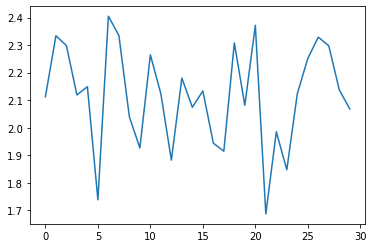

In [252]:
_train_X, _train_y, _valid_X, _valid_y = random_split_train_val(train_X, train_y, num_val=int(len(train_y)*0.2))
clf = linear_classifer.LinearSoftmaxClassifier()
lh = clf.fit(_train_X, _train_y, epochs=30, learning_rate=1e-2, batch_size=10, reg=1e-6)
plt.plot(lh)
y_pred = clf.predict(_valid_X)
print(multiclass_accuracy(_valid_y, y_pred))

test_pred = clf.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy))

Epoch 0, loss: 2.277964
Epoch 1, loss: 2.222678
Epoch 2, loss: 2.209807
Epoch 3, loss: 2.171210
Epoch 4, loss: 2.155068
Epoch 5, loss: 2.212577
Epoch 6, loss: 2.162674
Epoch 7, loss: 2.176101
Epoch 8, loss: 2.168588
Epoch 9, loss: 2.158508
Epoch 10, loss: 2.119490
Epoch 11, loss: 2.193832
Epoch 12, loss: 2.136127
Epoch 13, loss: 2.125963
Epoch 14, loss: 2.125983
Epoch 15, loss: 2.167025
Epoch 16, loss: 2.108738
Epoch 17, loss: 2.114171
Epoch 18, loss: 2.122271
Epoch 19, loss: 2.137817
Epoch 20, loss: 2.126613
Epoch 21, loss: 2.172860
Epoch 22, loss: 2.148029
Epoch 23, loss: 2.102540
Epoch 24, loss: 2.081570
Epoch 25, loss: 2.061144
Epoch 26, loss: 2.159167
Epoch 27, loss: 2.094899
Epoch 28, loss: 2.095825
Epoch 29, loss: 2.057915
Epoch 30, loss: 2.109384
Epoch 31, loss: 2.067522
Epoch 32, loss: 2.078311
Epoch 33, loss: 2.141052
Epoch 34, loss: 2.114940
Epoch 35, loss: 2.041407
Epoch 36, loss: 2.110628
Epoch 37, loss: 2.130607
Epoch 38, loss: 2.104057
Epoch 39, loss: 1.999212
Epoch 40, 

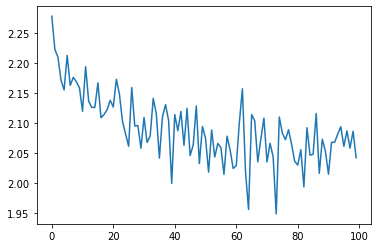

In [256]:
_train_X, _train_y, _valid_X, _valid_y = random_split_train_val(train_X, train_y, num_val=int(len(train_y)*0.2))
clf = linear_classifer.LinearSoftmaxClassifier()
lh = clf.fit(_train_X, _train_y, epochs=100, learning_rate=1e-1, batch_size=300, reg=1e-4)
plt.plot(lh)
y_pred = clf.predict(_valid_X)
print(multiclass_accuracy(_valid_y, y_pred))

test_pred = clf.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy))